In [1]:
import dataclasses

import corner
import emcee
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize

from cr_knee_fit.fit_data import FitData
from cr_knee_fit.inference import make_loglikelihood, make_logposterior
from cr_knee_fit.model import Model, ModelConfig
from cr_knee_fit.types_ import Experiment, Primary

In [2]:
from cr_knee_fit.cr_model import CosmicRaysModelConfig

EXPERIMENTS = list(Experiment)

config = ModelConfig(
    cr_model_config=CosmicRaysModelConfig(
        components=[
            [Primary.H],
            [Primary.He],
            sorted(p for p in Primary if p not in {Primary.H, Primary.He}),
        ],
        n_breaks=2,
    ),
    shifted_experiments=[e for e in EXPERIMENTS if e is not Experiment.AMS02],
)

fit_data = FitData.load(
    experiments=EXPERIMENTS,
    primaries=config.cr_model_config.primaries,
    R_bounds=(7e2, 1e8),
)

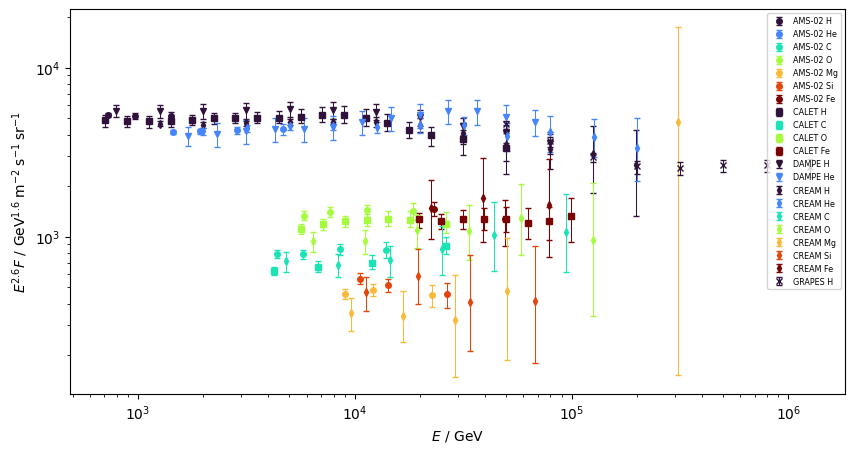

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))

for _, p_data in fit_data.spectra.items():
    for _, data in p_data.items():
        data.plot(scale=2.6, ax=ax)

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")

In [4]:
from scipy import stats
from cr_knee_fit.cr_model import CosmicRaysModel, RigidityBreak, SharedPowerLaw
from cr_knee_fit.shifts import ExperimentEnergyScaleShifts


def initial_guess_model(config: ModelConfig) -> Model:
    return Model(
        cr_model=CosmicRaysModel(
            base_spectra=[
                (
                    SharedPowerLaw(
                        lgI_per_primary={
                            primary: stats.norm.rvs(loc=-4, scale=0.5) - 2.6 * np.log10(primary.Z)
                            for primary in component
                        },
                        alpha=stats.norm.rvs(loc=2.7, scale=0.1),
                    )
                )
                for component in config.cr_model_config.components
            ],
            breaks=[
                RigidityBreak(
                    lg_R=stats.norm.rvs(loc=4.2, scale=0.1),
                    d_alpha=stats.norm.rvs(loc=0.3, scale=0.05),
                    lg_sharpness=stats.norm.rvs(loc=np.log10(5), scale=0.01),
                ),
                RigidityBreak(
                    lg_R=stats.norm.rvs(loc=5.3, scale=0.1),
                    d_alpha=stats.norm.rvs(loc=-0.3, scale=0.05),
                    lg_sharpness=stats.norm.rvs(loc=np.log10(10), scale=0.01),
                ),
            ],
        ),
        energy_shifts=ExperimentEnergyScaleShifts(
            lg_shifts={exp: stats.norm.rvs(loc=0, scale=0.01) for exp in config.shifted_experiments}
        ),
    )

## Pre-optimization


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 47.40540339041998
             x: [-4.101e+00  2.617e+00 ... -1.804e-01  8.089e-01]
           nit: 4424
          nfev: 5822
 final_simplex: (array([[-4.101e+00,  2.617e+00, ..., -1.804e-01,
                         8.089e-01],
                       [-4.101e+00,  2.617e+00, ..., -1.804e-01,
                         8.090e-01],
                       ...,
                       [-4.101e+00,  2.617e+00, ..., -1.805e-01,
                         8.090e-01],
                       [-4.101e+00,  2.617e+00, ..., -1.805e-01,
                         8.090e-01]]), array([ 4.741e+01,  4.741e+01, ...,  4.741e+01,  4.741e+01]))
  1.                          lgI_{H} = -4.10e+00
  2.                        alpha_{H} = 2.62e+00
  3.                         lgI_{He} = -4.96e+00
  4.                       alpha_{He} = 2.55e+00
  5.                          lgI_{C} = -6.96e+00
  6.            

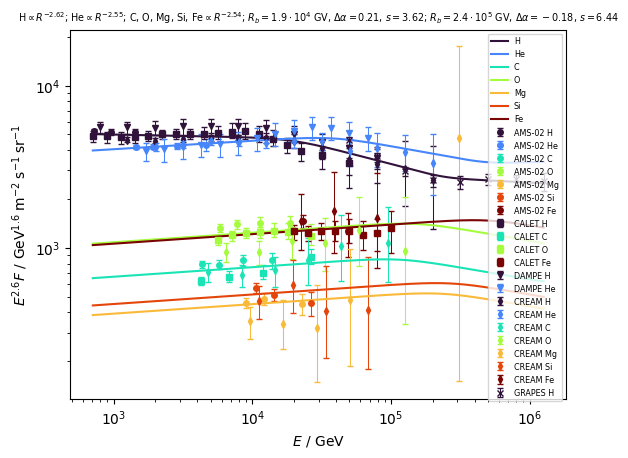

In [5]:


pre_optimization_config = dataclasses.replace(config, shifted_experiments={})
loglike = make_loglikelihood(fit_data, pre_optimization_config)


def minimized_fn(v: np.ndarray) -> float:
    return -loglike(v)


res = optimize.minimize(
    minimized_fn,
    x0=initial_guess_model(pre_optimization_config).pack(),
    method="Nelder-Mead",
    options={
        "maxiter": 100_000,
    },
)
print(res)

mle_model = Model.unpack(res.x, layout_info=pre_optimization_config)
mle_model.plot(fit_data, scale=2.6)
mle_model.print_params()

In [6]:
init_model = initial_guess_model(config)

In [7]:
n_steps = 15_000
n_walkers = 128
n_dim = init_model.ndim()

sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=make_logposterior(fit_data, config),
)
initial_state = np.array([initial_guess_model(config).pack() for _ in range(n_walkers)])
sampler.run_mcmc(initial_state, nsteps=n_steps, progress=True)
print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

tau = sampler.get_autocorr_time(quiet=True)
print(f"{tau = }")

burn_in = 5 * int(tau.max())
thin = 2 * int(tau.max())

print(f"{burn_in = } {thin = }")

theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)  # type: ignore
print(f"MCMC sample ready, shape: {theta_sample.shape}")

100%|██████████| 15000/15000 [26:27<00:00,  9.45it/s]


Acceptance fraction: 0.28338385416666667


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: [178.652815   208.70760822  68.67011639 274.39422944  63.36328086
  63.68349099  98.39743305  62.55041364 126.55230147 304.29239533
 398.0164961  435.27452071 257.47182302 448.96168045 417.55591121
 267.47151963 414.51634519 270.86525988 461.4627402  339.23923656]


tau = array([178.652815  , 208.70760822,  68.67011639, 274.39422944,
        63.36328086,  63.68349099,  98.39743305,  62.55041364,
       126.55230147, 304.29239533, 398.0164961 , 435.27452071,
       257.47182302, 448.96168045, 417.55591121, 267.47151963,
       414.51634519, 270.86525988, 461.4627402 , 339.23923656])
burn_in = 2305 thin = 922
MCMC sample ready, shape: (1664, 20)


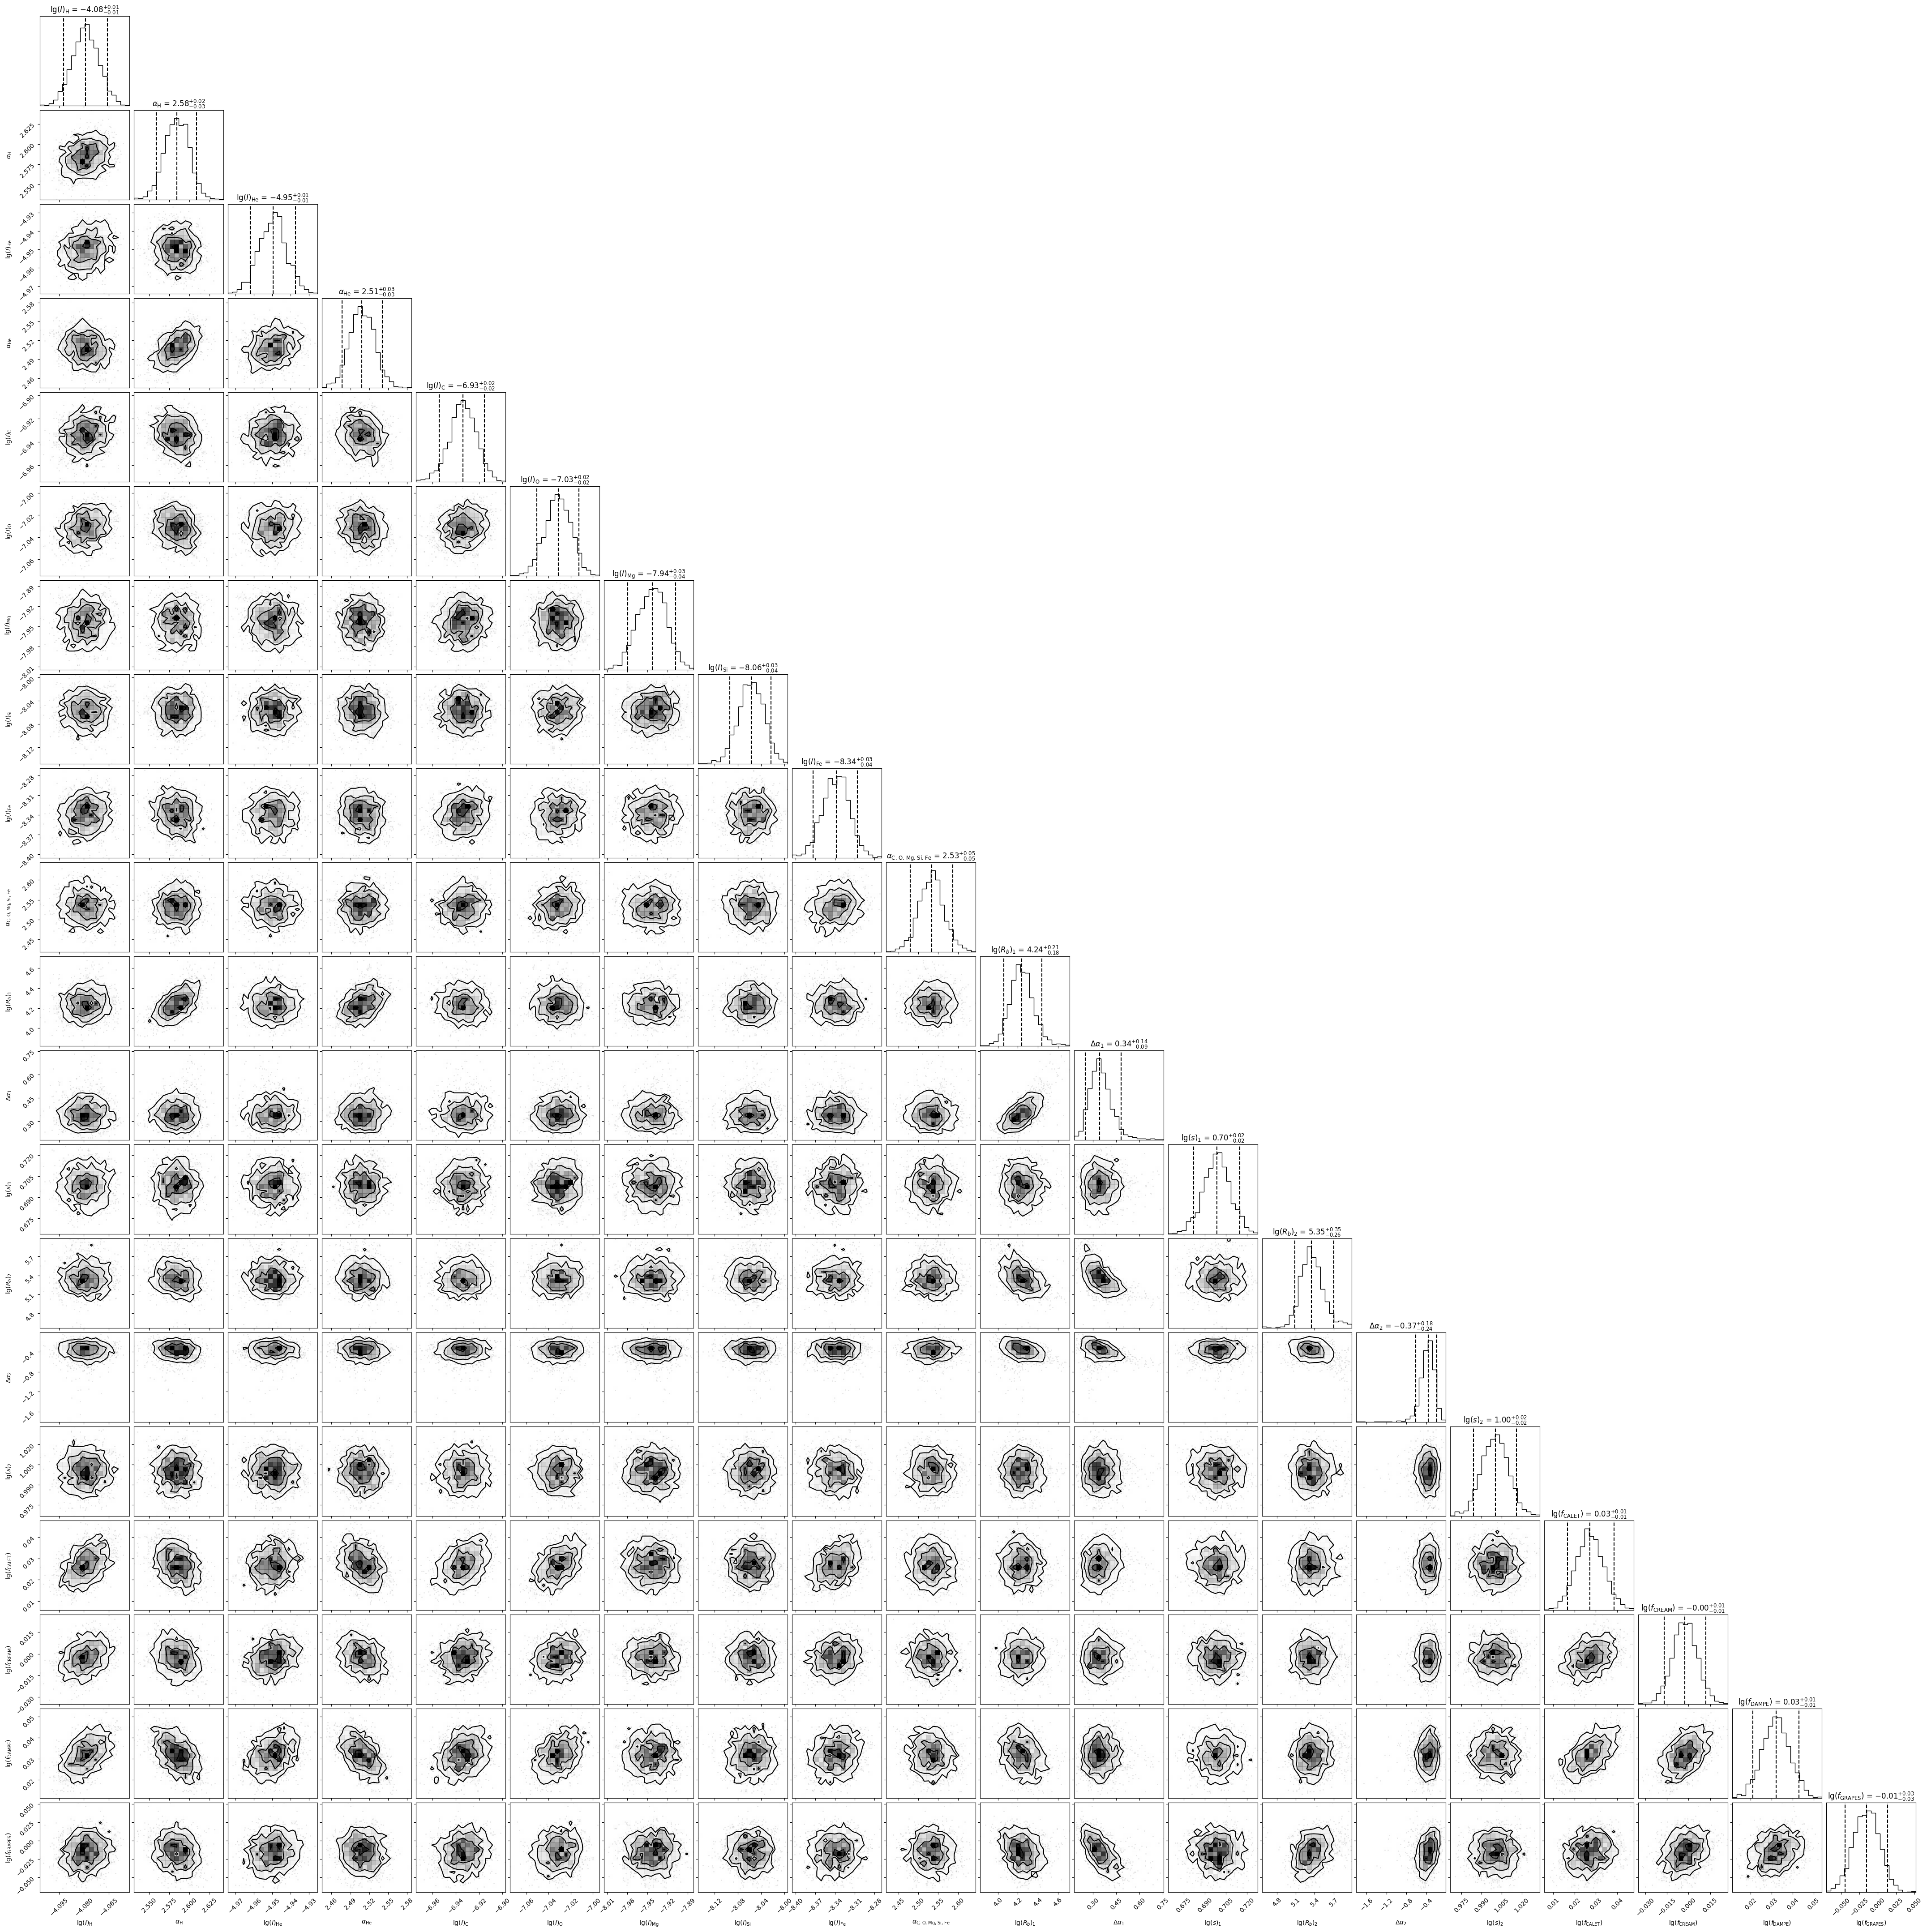

In [8]:

sample_to_plot = theta_sample
sample_labels = ["$" + label + "$" for label in init_model.labels(True)]

_ = corner.corner(
    sample_to_plot,
    labels=sample_labels,
    show_titles=True,
    quantiles=[0.05, 0.5, 0.95],
)

  1.                          lgI_{H} = -4.08e+00
  2.                        alpha_{H} = 2.58e+00
  3.                         lgI_{He} = -4.95e+00
  4.                       alpha_{He} = 2.51e+00
  5.                          lgI_{C} = -6.93e+00
  6.                          lgI_{O} = -7.03e+00
  7.                         lgI_{Mg} = -7.94e+00
  8.                         lgI_{Si} = -8.06e+00
  9.                         lgI_{Fe} = -8.34e+00
 10.         alpha_{C, O, Mg, Si, Fe} = 2.53e+00
 11.                        lg(R_b)_1 = 4.24e+00
 12.                        d_alpha_1 = 3.44e-01
 13.                          lg(s)_1 = 6.99e-01
 14.                        lg(R_b)_2 = 5.35e+00
 15.                        d_alpha_2 = -3.65e-01
 16.                          lg(s)_2 = 1.00e+00
 17.                      lg(f_CALET) = 2.72e-02
 18.                      lg(f_CREAM) = 3.21e-02
 19.                      lg(f_DAMPE) = -2.74e-03
 20.                     lg(f_GRAPES) = -1.48e-02


(np.float64(334.8609921184278), np.float64(2663278.2587127783))

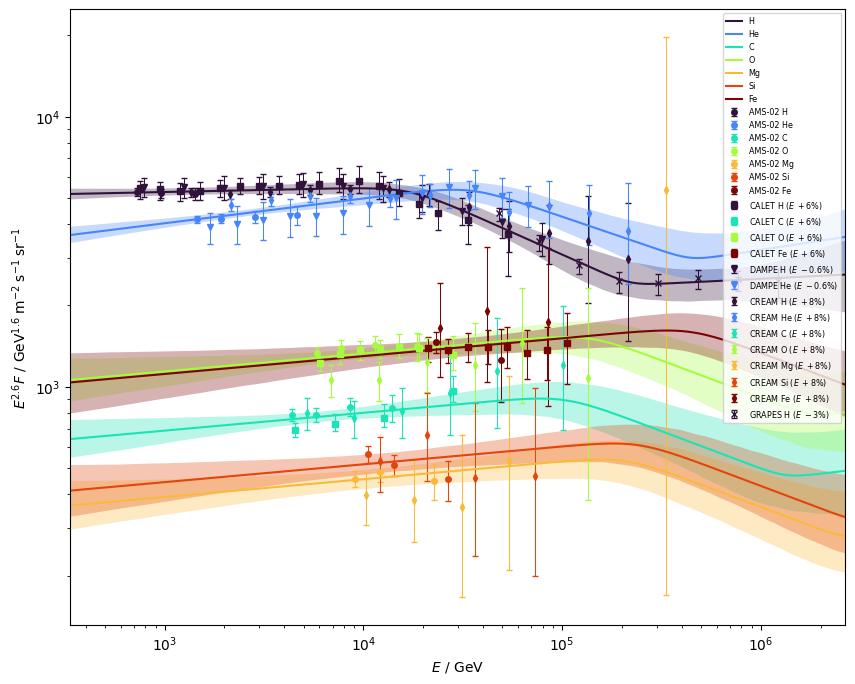

In [10]:
import itertools

from cr_knee_fit.utils import add_log_margin


scale = 2.6
model_sample = [Model.unpack(theta, layout_info=config) for theta in theta_sample]
median_model = Model.unpack(np.median(theta_sample, axis=0), layout_info=config)
median_model.print_params()

fig, ax = plt.subplots(figsize=(10, 8))

for exp, data_by_particle in fit_data.spectra.items():
    for _, data in data_by_particle.items():
        data.with_shifted_energy_scale(f=median_model.energy_shifts.f(exp)).plot(scale=scale, ax=ax)

primaries = median_model.cr_model.layout_info().primaries
Emin, Emax = add_log_margin(fit_data.E_min(), fit_data.E_max())
median_model.cr_model.plot(Emin, Emax, scale=scale, axes=ax)

for p in primaries:
    primary_energies = list(
        itertools.chain.from_iterable(
            exp_spectra[p].E for exp_spectra in fit_data.spectra.values() if p in exp_spectra
        )
    )
    # Emin_p, Emax_p = add_log_margin(min(primary_energies), max(primary_energies))
    Emin_p = Emin
    Emax_p = Emax
    E_grid = np.logspace(np.log10(Emin_p), np.log10(Emax_p), 100)
    E_factor = E_grid**scale
    upper = []
    lower = []
    for E in E_grid:
        predictions = np.array([model.cr_model.compute(E, p) for model in model_sample])
        lower.append(np.quantile(predictions, q=0.05))
        upper.append(np.quantile(predictions, q=0.95))
    ax.fill_between(
        E_grid,
        E_factor * lower,
        E_factor * upper,
        color=p.color,
        alpha=0.3,
        edgecolor="none",
    )

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(Emin, Emax)
